In [2]:
%matplotlib inline

In [3]:
import brightway2 as bw
import numpy as np
import pyprind
from matplotlib import pyplot as plt
import seaborn as sb

In [4]:
bw.projects.set_current('Dimension reduction')

In [5]:
bw.databases

Databases dictionary with 2 object(s):
	biosphere3
	ecoinvent 3.6 cutoff

In [23]:
markets = [obj for obj in bw.Database("ecoinvent 3.6 cutoff") if obj['name'].startswith("market for")]
len(markets)

5397

In [9]:
eidb = bw.Database("ecoinvent 3.6 cutoff")
random_act = eidb.random()
random_act

'treatment of sulfidic tailings, generic, tailings impoundment' (kilogram, GLO, None)

In [7]:
methods = [obj for obj in bw.methods 
           if obj[0] == 'ReCiPe Midpoint (E) V1.13'
           and obj[1] != 'natural land transformation']
methods

[('ReCiPe Midpoint (E) V1.13', 'freshwater ecotoxicity', 'FETPinf'),
 ('ReCiPe Midpoint (E) V1.13', 'human toxicity', 'HTPinf'),
 ('ReCiPe Midpoint (E) V1.13', 'marine ecotoxicity', 'METPinf'),
 ('ReCiPe Midpoint (E) V1.13', 'terrestrial ecotoxicity', 'TETPinf'),
 ('ReCiPe Midpoint (E) V1.13', 'metal depletion', 'MDP'),
 ('ReCiPe Midpoint (E) V1.13', 'agricultural land occupation', 'ALOP'),
 ('ReCiPe Midpoint (E) V1.13', 'climate change', 'GWP500'),
 ('ReCiPe Midpoint (E) V1.13', 'fossil depletion', 'FDP'),
 ('ReCiPe Midpoint (E) V1.13', 'freshwater eutrophication', 'FEP'),
 ('ReCiPe Midpoint (E) V1.13', 'ionising radiation', 'IRP_HE'),
 ('ReCiPe Midpoint (E) V1.13', 'marine eutrophication', 'MEP'),
 ('ReCiPe Midpoint (E) V1.13', 'ozone depletion', 'ODPinf'),
 ('ReCiPe Midpoint (E) V1.13', 'particulate matter formation', 'PMFP'),
 ('ReCiPe Midpoint (E) V1.13', 'photochemical oxidant formation', 'POFP'),
 ('ReCiPe Midpoint (E) V1.13', 'terrestrial acidification', 'TAP500'),
 ('ReCiPe Mi

In [10]:
lca = bw.LCA({random_act: 1}, methods[0])
lca.lci()
lca.lcia()

In [11]:
lca.biosphere_matrix

<2077x18121 sparse matrix of type '<class 'numpy.float64'>'
	with 407437 stored elements in Compressed Sparse Row format>

In [14]:
n = lca.biosphere_matrix.shape[0]

In [19]:
results_array = np.zeros((len(eidb), len(methods)))

In [20]:
method_matrices = []

for m in methods:
    lca.switch_method(m)
    method_matrices.append(lca.characterization_matrix.copy())

In [21]:
for i, market in enumerate(pyprind.prog_bar(eidb)):
    lca.redo_lci({market: 1})
    for j, method in enumerate(methods):
        vector = np.ravel((method_matrices[j] * lca.inventory).sum(axis=1))
        # Normalize to fractions of total
        if not vector.sum():
            continue
        #vector /= vector.sum()
        results_array[i, j] = vector.sum()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:09:18


Might want to save this result to avoid recalculation

In [22]:
results_array.shape

(18121, 17)

In [24]:
new_matrix = {}
act_id = []
act_name = []
isic_num = []
cpc_num = []
n = 0
for obj in pyprind.prog_bar(eidb):
    act_id.append(lca.activity_dict[obj.key])
    act_name.append(obj['name'])
    new_matrix[lca.activity_dict[obj.key]] = results_array[n]
    n = n+1
    obj_class = obj['classifications']
    obj_class_whole = ()
    if obj['classifications']:
        for i in range(len(obj_class)):
            obj_class_whole = obj_class_whole + obj_class[i]
            if 'ISIC rev.4 ecoinvent' in obj_class[i]:
                isic = obj_class[i][1]
                isic_num.append(isic.split(':')[0]) 
            if 'CPC' in obj_class[i]:
                cpc = obj_class[i][1]
                cpc_num.append(cpc.split(':')[0])
            if i == len(obj_class)-1 and 'ISIC rev.4 ecoinvent' not in obj_class_whole:
                isic_num.append(0)
            if i == len(obj_class)-1 and 'CPC' not in obj_class_whole:
                cpc_num.append(0)
                
    else:
        isic_num.append(0)
        cpc_num.append(0)

len(act_id),len(act_name),len(cpc_num),len(isic_num),len(new_matrix)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


(18121, 18121, 18121, 18121, 18121)

In [25]:
import pandas as pd
df = pd.DataFrame(new_matrix)
df_new = df.T
df_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
15529,-0.079601,-5.566940,-45.069770,-0.010429,-0.043661,-0.011355,-0.256920,-0.068213,-0.000086,-0.013576,-0.000129,-1.417843e-08,-0.000794,-0.001067,-0.001106,-0.006859,-0.101975
17376,475.132795,196414.944085,257207.740810,10.986757,2929.665391,572.048822,9625.226522,2716.597592,3.955603,617.359308,2.149141,4.977222e-04,25.379964,32.720289,58.242709,92.684841,35.442032
16730,0.031443,9.166100,12.093716,0.051500,0.080857,4.561921,5.346944,0.288102,0.000764,0.048238,0.012639,1.243642e-07,0.006223,0.007352,0.006429,0.015717,0.009200
5272,63.933813,26692.975957,35134.155483,0.848325,65.225869,41.714725,1262.940750,353.817704,0.609529,117.497791,0.247673,4.838492e-05,3.302899,3.436838,5.672624,6.587273,6.214446
3674,0.003417,1.338842,1.120465,0.004552,0.005696,0.014866,40.119477,0.112494,0.000102,0.021250,0.001124,5.776233e-08,0.092395,0.062018,0.030209,0.000744,0.001043


In [26]:
df_act_cpc_isic = pd.DataFrame({'activity':act_id,
                                'name':act_name,
                                'ISIC':isic_num,
                                'CPC':cpc_num},)
df_act_cpc_isic = df_act_cpc_isic.set_index('activity')
df_act_cpc_isic.head()

,name,ISIC,CPC
activity,,,
15529,"electricity production, hydro, run-of-river",3510,17100
17376,"electricity production, natural gas, combined ...",3510,17100
16730,"treatment of municipal solid waste, incineration",3821,17300
5272,"market for land tenure, arable land, measured ...",68,7
3674,"market for sawnwood, board, softwood, raw, dri...",1610,31101


In [27]:
df_whole_data = df_act_cpc_isic.merge(df_new,right_index=True,left_index=True)
df_whole_data.head()

,name,ISIC,CPC,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
activity,,,,,,,,,,,,,,,,,,,,
15529,"electricity production, hydro, run-of-river",3510,17100,-0.079601,-5.566940,-45.069770,-0.010429,-0.043661,-0.011355,-0.256920,-0.068213,-0.000086,-0.013576,-0.000129,-1.417843e-08,-0.000794,-0.001067,-0.001106,-0.006859,-0.101975
17376,"electricity production, natural gas, combined ...",3510,17100,475.132795,196414.944085,257207.740810,10.986757,2929.665391,572.048822,9625.226522,2716.597592,3.955603,617.359308,2.149141,4.977222e-04,25.379964,32.720289,58.242709,92.684841,35.442032
16730,"treatment of municipal solid waste, incineration",3821,17300,0.031443,9.166100,12.093716,0.051500,0.080857,4.561921,5.346944,0.288102,0.000764,0.048238,0.012639,1.243642e-07,0.006223,0.007352,0.006429,0.015717,0.009200
5272,"market for land tenure, arable land, measured ...",68,7,63.933813,26692.975957,35134.155483,0.848325,65.225869,41.714725,1262.940750,353.817704,0.609529,117.497791,0.247673,4.838492e-05,3.302899,3.436838,5.672624,6.587273,6.214446
3674,"market for sawnwood, board, softwood, raw, dri...",1610,31101,0.003417,1.338842,1.120465,0.004552,0.005696,0.014866,40.119477,0.112494,0.000102,0.021250,0.001124,5.776233e-08,0.092395,0.062018,0.030209,0.000744,0.001043


In [51]:
df_whole_data.to_csv('all_act_isic_cpc_lcia17.csv')

In [2]:
import pandas as pd
df = pd.read_csv('all_act_isic_cpc_lcia17.csv')
df = df.drop(columns = ['ISIC','name','CPC'])
df = df.set_index('activity')
df_new = df.copy()
df_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
activity,,,,,,,,,,,,,,,,,
6883,0.001401,0.931125,1.038078,0.000728,0.006306,0.001304,0.133040,0.049687,0.000012,0.009653,0.000031,2.392982e-08,0.000318,0.000861,0.000699,0.009167,0.000214
9504,0.037511,10.154455,14.485227,0.011873,0.098636,4.131966,0.784532,0.177059,0.000347,0.120683,0.028448,8.740335e-08,0.002212,0.004540,0.007685,0.248558,0.025102
17429,0.215186,83.076650,113.776706,0.005026,0.679820,0.388782,3.647334,0.992046,0.002624,0.320431,0.005686,5.327838e-07,0.009599,0.014103,0.024653,0.070564,0.070011
15464,0.051045,17.458114,25.995948,0.000940,0.091100,0.099172,1.307503,0.289341,0.000394,0.182616,0.000209,1.009672e-07,0.001204,0.002168,0.003198,0.007364,0.007250
15678,0.050692,6.846952,12.850088,0.151651,0.058360,1.907746,1.036235,0.210886,0.000959,0.047949,0.020675,8.814881e-08,0.004145,0.006123,0.021978,0.013912,0.360177


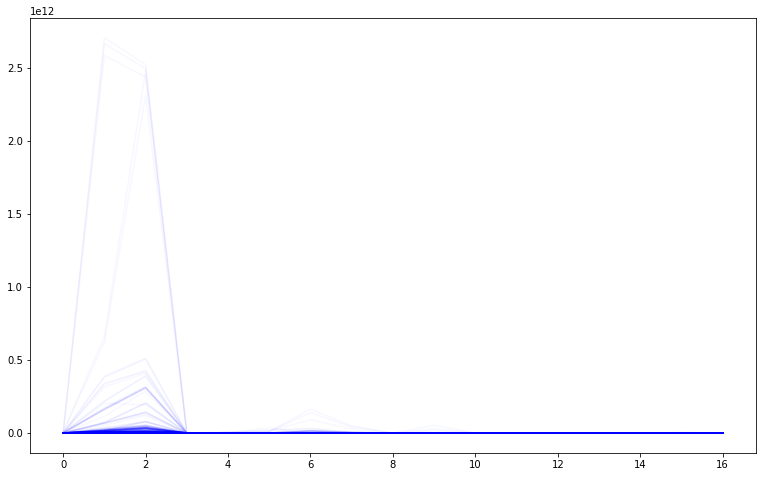

In [29]:
df_normalized.T.plot(figsize = (13,8), legend = False, 
                    color = 'blue', alpha = 0.03)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [6]:
df_normalized=df_new.copy()
for i in range(17):
    df_normalized[i]=df_normalized[str(i)]
    df_normalized = df_normalized.drop(columns = [str(i)])
x = df_normalized.values.copy()
sc = MinMaxScaler()
X = sc.fit_transform(x)
for i in range(17):
    df_normalized[i] = X.T[i]
df_normalized.tail(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
activity,,,,,,,,,,,,,,,,,
11532,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
1245,0.000019,0.000011,0.000014,0.000428,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
17511,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
12770,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
6815,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
10715,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
3660,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
13783,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008
14168,0.000019,0.000011,0.000014,0.000427,0.000071,0.000007,0.000028,0.000035,0.000006,0.000052,0.000032,0.000095,0.000029,0.000077,0.000037,0.000092,0.000008


In [8]:
from matplotlib import pyplot as plt

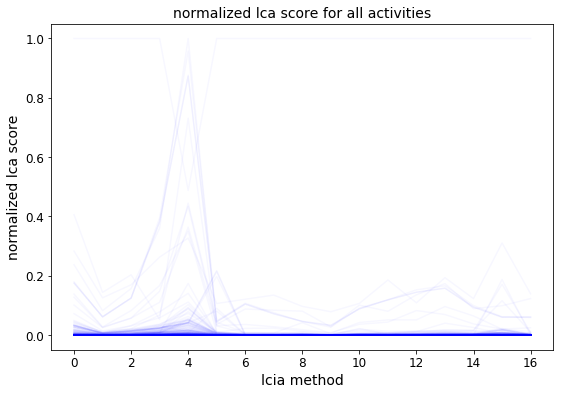

In [9]:
df_normalized.T.plot(figsize = (9,6), legend = False, 
                    color = 'blue', alpha = 0.03)
plt.xlabel ("lcia method", fontsize = 14)  # create axes labels
plt.ylabel ("normalized lca score", fontsize = 14)
plt.title ('normalized lca score for all activities',fontsize = 14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()

In [33]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [39]:
X_dbscan = df_new_normalized.values.copy()#StandardScaler().fit_transform(df_new)

db = DBSCAN(eps = 0.15, min_samples = 20).fit(X_dbscan)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_dbscan, labels))

Estimated number of clusters: 1
Estimated number of noise points: 36
Silhouette Coefficient: 0.996
